In [33]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

## Model Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC

In [34]:
## Tuned params
params = {'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 8,
 'missing': None,
 'monotone_constraints': None,
 'n_estimators': 12,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'nthread': 4,
 'seed': 27,
 'tree_method': 'hist'}

In [35]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv").iloc[:,1:]
df = df.drop_duplicates(subset='website')

In [36]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [37]:
# trained_tf_idf_df = df[(df.label == 'APPROVED') & (df.tnc_refund_policy_exist == 1)]\
# .sample(n=50, replace=False, random_state=50)
# trained_tf_idf_df.to_csv("train_tf_idf.csv", index=False)
# df = df[~df.website.isin(trained_tf_idf_df.website)]

In [38]:
# df.groupby("label").size()

In [39]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [40]:
# X = df.iloc[:, 1:8]
X = df.iloc[:, 2:8]

## Train/Test Split

In [41]:
X.head(1)

,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,1.0,1.0,1.0,0.0,1.0,1.0


In [42]:
X.columns

Index(['link_contact_us_exist', 'cu_email_exist', 'cu_phone_number_exist',
       'link_about_us_exist', 'link_tnc_exist', 'tnc_refund_policy_exist'],
      dtype='object')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [44]:
## Gaussian Naive Bayes has a good ability to predict REJECTED websites, but it is hard to got a low FP Rate with this model.
## While XGBoost provides more reliable model with low FP rate and enough TP rate
## Though, it goes back to the business decision which rate is more important

# model_choice = GaussianNB()
model_choice = BernoulliNB()
# model_choice = MultinomialNB()
# model_choice = XGBClassifier(**params)

In [45]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [46]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [47]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [48]:
y_pred_proba = clf.predict_proba(X_test)

In [49]:
np.round(accuracy_score(y_test, y_pred), 2)

0.88

In [50]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [51]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [52]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.87, 0.122)

In [53]:
tn, fp, fn, tp

(65, 9, 3, 20)

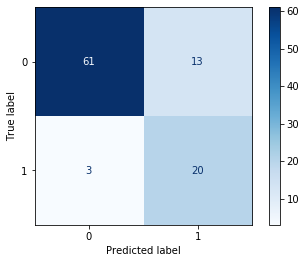

In [54]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [56]:
auc_score = auc(fpr, tpr)

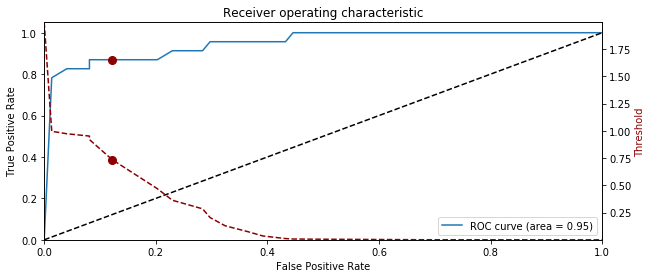

 -- Optimum Threshold -- 
        fpr       tpr     1-fpr        tf  thresholds
5  0.121622  0.869565  0.878378 -0.008813    0.736728


In [57]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# find optimum thresholds
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
ax2.set_ylabel('Threshold',color='darkred')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
print(" -- Optimum Threshold -- ")
print(df_thresh)

In [58]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 1.9961690245614045
TPR 0.782608695652174, FPR 0.013513513513513514, Threshold 0.9961690245614045
TPR 0.8260869565217391, FPR 0.04054054054054054, Threshold 0.9736459581906247
TPR 0.8260869565217391, FPR 0.08108108108108109, Threshold 0.9523769541214944
TPR 0.8695652173913043, FPR 0.08108108108108109, Threshold 0.920036832768326
TPR 0.8695652173913043, FPR 0.12162162162162163, Threshold 0.7367280663362746
TPR 0.8695652173913043, FPR 0.20270270270270271, Threshold 0.4694616107053852
TPR 0.9130434782608695, FPR 0.22972972972972974, Threshold 0.3630348717738261
TPR 0.9130434782608695, FPR 0.28378378378378377, Threshold 0.28448133999479547
TPR 0.9565217391304348, FPR 0.2972972972972973, Threshold 0.20414847636067426
TPR 0.9565217391304348, FPR 0.32432432432432434, Threshold 0.12860366293706496
TPR 0.9565217391304348, FPR 0.36486486486486486, Threshold 0.074911124183608
TPR 0.9565217391304348, FPR 0.3918918918918919, Threshold 0.035163960

## Bootstrapped

In [59]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.9438888888888889, Accuracy:0.8556701030927835
Iteration 1: AUC:0.9345841784989858, Accuracy:0.7835051546391752
Iteration 2: AUC:0.9406580493537016, Accuracy:0.845360824742268
Iteration 3: AUC:0.973458904109589, Accuracy:0.8350515463917526
Iteration 4: AUC:0.9609967497291441, Accuracy:0.9072164948453608
Iteration 5: AUC:0.9132275132275133, Accuracy:0.7731958762886598
Iteration 6: AUC:0.9685096153846154, Accuracy:0.8762886597938144
Iteration 7: AUC:0.9208333333333333, Accuracy:0.7731958762886598
Iteration 8: AUC:0.9534817351598174, Accuracy:0.8247422680412371
Iteration 9: AUC:0.9042303172737953, Accuracy:0.8247422680412371
Iteration 10: AUC:0.9632505175983437, Accuracy:0.845360824742268
Iteration 11: AUC:0.9046653144016228, Accuracy:0.7628865979381443
Iteration 12: AUC:0.9312169312169312, Accuracy:0.8144329896907216
Iteration 13: AUC:0.9312169312169312, Accuracy:0.8247422680412371
Iteration 14: AUC:0.9240867579908676, Accuracy:0.8144329896907216
Iteration 15: AUC:0.948

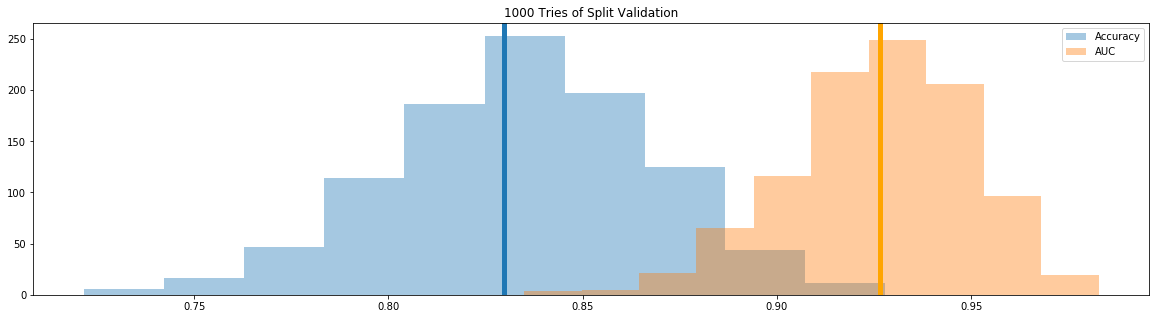

Accuracy mean: 0.83
AUC mean: 0.93


In [60]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Model Comparison

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
## Initiate models
models = []
models.append(('K-Nearest Neighbour', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Bernoulli Naive Bayes', BernoulliNB()))
models.append(('Multinomial Naive Bayes', MultinomialNB()))
models.append(('XGBoost Classifier', XGBClassifier(**params)))

In [68]:
## Results
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    ## AUC Scoring
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print('%s: \nAUC Mean %f, STD %f\n'%(name, cv_results.mean(), cv_results.std()))

K-Nearest Neighbour: 
AUC Mean 0.873059, STD 0.050799

Decision Tree Classifier: 
AUC Mean 0.790699, STD 0.066414

Gaussian Naive Bayes: 
AUC Mean 0.918549, STD 0.051130

Bernoulli Naive Bayes: 
AUC Mean 0.922445, STD 0.051292

Multinomial Naive Bayes: 
AUC Mean 0.717922, STD 0.100225

XGBoost Classifier: 
AUC Mean 0.886328, STD 0.040150



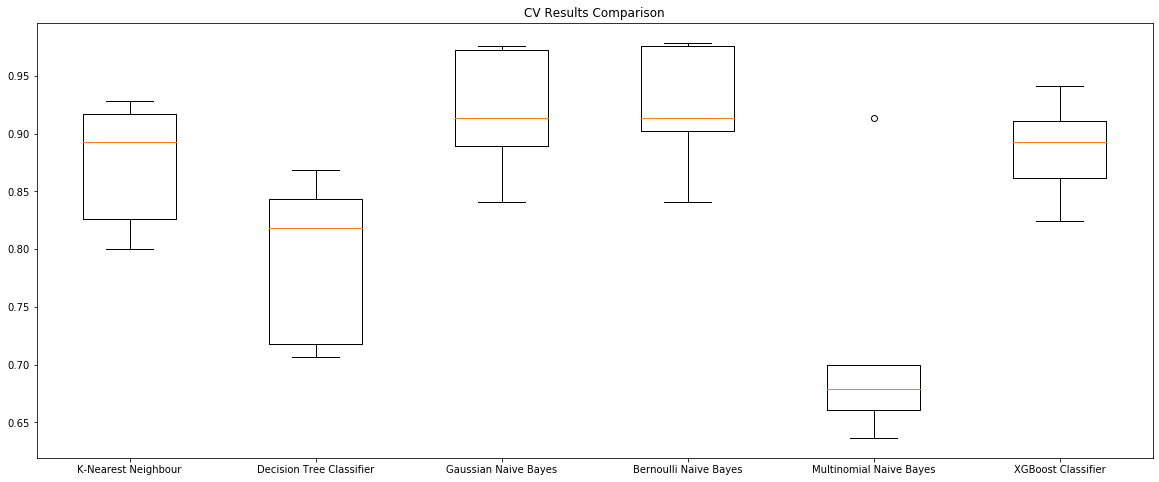

In [69]:
## Results Distribution
plt.figure(figsize=(20,8))
plt.boxplot(results, labels=names)
plt.title('CV Results Comparison')
plt.show()

## Dump To Pickle

In [33]:
clf = model_choice
clf = clf.fit(X, y)
pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [34]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()